Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets 
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

# Explore tabular data for superviesd machine learning 🍌

Wrangling your dataset is often the most challenging and time-consuming part of the modeling process.

In today's lesson, we’ll work with a dataset of [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)!

Let’s get set up:

In [3]:
# Download data
import requests

def download(url):
    filename = url.split('/')[-1]
    print(f'Downloading {url}')
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)
    print(f'Downloaded {filename}')

download('https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz')

Downloaded instacart_online_grocery_shopping_2017_05_01.tar.gz


In [11]:
# Uncompress data
import tarfile
tarfile.open('instacart_online_grocery_shopping_2017_05_01.tar.gz').extractall()

FileNotFoundError: [Errno 2] No such file or directory: 'instacart_online_grocery_shopping_2017_05_01.tar.gz'

In [12]:
# Change directory to where the data was uncompressed
%cd instacart_2017_05_01

[Errno 2] No such file or directory: 'instacart_2017_05_01'
/Users/martincampbell/DS-Unit-2-Applied-Modeling/module2-wrangle-ml-datasets/instacart_2017_05_01


In [13]:
# Print the csv filenames
from glob import glob
for filename in glob('*.csv'):
    print(filename)

products.csv
orders.csv
order_products__train.csv
departments.csv
aisles.csv
order_products__prior.csv


In [15]:
# For each csv file, look at its shape & head
import pandas as pd
from IPython.display import display

products_df = pd.read_csv('products.csv')

In [17]:
def preview():
  for filename in glob('*.csv'):
    df = pd.read_csv(filename)
    print('\n', filename, df.shape)
    display(df.head())

In [18]:
preview()


 products.csv (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13



 orders.csv (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0



 order_products__train.csv (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1



 departments.csv (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol



 aisles.csv (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation



 order_products__prior.csv (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### The original task was complex ...

[The Kaggle competition said,](https://www.kaggle.com/c/instacart-market-basket-analysis/data):

> The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order.

> orders.csv: This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders.

Each row in the submission is an order_id from the test set, followed by product_id(s) predicted to be reordered.

> sample_submission.csv: 
```
order_id,products
17,39276 29259
34,39276 29259
137,39276 29259
182,39276 29259
257,39276 29259
```

### ... but we can simplify!

Simplify the question, from "Which products will be reordered?" (Multi-class, [multi-label](https://en.wikipedia.org/wiki/Multi-label_classification) classification) to **"Will customers reorder this one product?"** (Binary classification)

Which product? How about **the most frequently ordered product?**

### Questions:

- What is the most frequently ordered product?
- How often is this product included in a customer's next order?
- Which customers have ordered this product before?
- How can we get a subset of data, just for these customers?
- What features can we engineer? We want to predict, will these customers reorder this product on their next order?

## Follow Along

### What was the most frequently ordered product?

In [19]:
order_products__train = pd.read_csv('order_products__train.csv')
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [20]:
order_products__train['product_id'].value_counts()

24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
47766     7409
47209     7293
16797     6494
26209     6033
27966     5546
39275     4966
27845     4908
30391     4613
45007     4589
22935     4290
24964     4158
4920      4059
46979     3868
40706     3823
8518      3818
4605      3762
42265     3597
45066     3551
31717     3526
5876      3505
44632     3359
43352     3279
28204     3257
5450      3103
8424      2932
         ...  
21188        1
36069        1
48355        1
13000        1
2767         1
2293         1
18118        1
14024        1
26305        1
37599        1
48353        1
2292         1
2765         1
41688        1
30969        1
6389         1
37598        1
9928         1
23806        1
19708        1
1740         1
3316         1
42712        1
36068        1
42209        1
44256        1
2764         1
4815         1
43736        1
46835        1
Name: product_id, Length: 39123, dtype: int64

In [23]:
temp = order_products__train.sort_values(by='product_id',
                                       ascending=False).head()
temp

,order_id,product_id,add_to_cart_order,reordered
891142,2198380,49688,10,0
1209047,2986153,49688,16,0
269349,655800,49688,10,1
1014644,2508423,49688,3,0
446055,1092104,49687,1,0


In [24]:
temp.groupby('product_id').count()

,order_id,add_to_cart_order,reordered
product_id,,,
49687,1,1,1
49688,4,4,4


In [25]:
order_products__train.groupby('product_id').order_id.count().sort_values(
    ascending=False
)

product_id
24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
47766     7409
47209     7293
16797     6494
26209     6033
27966     5546
39275     4966
27845     4908
30391     4613
45007     4589
22935     4290
24964     4158
4920      4059
46979     3868
40706     3823
8518      3818
4605      3762
42265     3597
45066     3551
31717     3526
5876      3505
44632     3359
43352     3279
28204     3257
5450      3103
8424      2932
         ...  
7965         1
29530        1
16204        1
39909        1
39906        1
29533        1
39903        1
16201        1
29535        1
7979         1
16196        1
7981         1
7983         1
7985         1
39873        1
29543        1
29547        1
39894        1
39893        1
29549        1
39880        1
39879        1
7997         1
29555        1
39878        1
29560        1
8001         1
29566        1
8005         1
24836        1
Name: order_id, Length: 39123, dtype: int64

In [27]:
# Product 24852 was ordered almost 20 thousand times
# Read the products table to figure out the name of it

products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [28]:
products[products.product_id == 24852]

,product_id,product_name,aisle_id,department_id
24851,24852,Banana,24,4


In [31]:
train = pd.merge(order_products__train, products, how='inner', on='product_id')
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16


In [32]:
train['product_name'].value_counts()

Banana                                                                        18726
Bag of Organic Bananas                                                        15480
Organic Strawberries                                                          10894
Organic Baby Spinach                                                           9784
Large Lemon                                                                    8135
Organic Avocado                                                                7409
Organic Hass Avocado                                                           7293
Strawberries                                                                   6494
Limes                                                                          6033
Organic Raspberries                                                            5546
Organic Blueberries                                                            4966
Organic Whole Milk                                                          

### How often are bananas included in a customer's next order?

There are [three sets of data](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b):

> "prior": orders prior to that users most recent order (3.2m orders)  
"train": training data supplied to participants (131k orders)  
"test": test data reserved for machine learning competitions (75k orders)

Customers' next orders are in the "train" and "test" sets. (The "prior" set has the orders prior to the most recent orders.)

We can't use the "test" set here, because we don't have its labels (only Kaggle & Instacart have them), so we don't know what products were bought in the "test" set orders.

So, we'll use the "train" set. It currently has one row per product_id and multiple rows per order_id.

But we don't want that. Instead we want one row per order_id, with a binary column: "Did the order include bananas?"

Let's wrangle!

In [33]:
# we want to crunch that whole thing down to a single row that just says
# yes, they ordered bananas

# first, let's engineer a boolean for whether or not it's a banana
train['bananas'] = train['product_name'] == 'Banana'

In [34]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
0,1,49302,1,1,Bulgarian Yogurt,120,16,False
1,816049,49302,7,1,Bulgarian Yogurt,120,16,False
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,False
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,False
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,False


In [36]:
train[train['product_name'] == 'Banana'].head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
129688,226,24852,2,0,Banana,24,4,True
129689,473,24852,2,0,Banana,24,4,True
129690,878,24852,2,1,Banana,24,4,True
129691,1042,24852,1,1,Banana,24,4,True
129692,1139,24852,1,1,Banana,24,4,True


In [40]:
# how often are bananas included in the customer's next order?

train['bananas'].value_counts(normalize=True)

False    0.986476
True     0.013524
Name: bananas, dtype: float64

In [43]:
# let's use groupby to simplify our data down to bananas only
train_wrangled = train.groupby('order_id')['bananas'].any().reset_index()
train_wrangled

,order_id,bananas
0,1,False
1,36,False
2,38,False
3,96,False
4,98,False
5,112,False
6,170,False
7,218,False
8,226,True
9,349,False


In [44]:
train_wrangled['bananas'].value_counts(normalize=True)

False    0.857281
True     0.142719
Name: bananas, dtype: float64

In [ ]:
# What is the most common hour of the day that bananas are ordered?
# What about the common hour for any order?
import numpy as np

train[train['bananas']]

In [46]:
# what other table do we need? Orders!

orders = pd.read_csv('orders.csv')
orders.head()



,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [47]:
# What hour of the day is most typical to place an order?

orders['order_hour_of_day'].value_counts(normalize=True)

10    0.084306
11    0.083227
15    0.082909
14    0.082735
13    0.081261
12    0.079753
16    0.079669
9     0.075360
17    0.066878
18    0.053466
8     0.052089
19    0.041089
20    0.030485
7     0.026853
21    0.022832
22    0.017967
23    0.011705
6     0.008924
0     0.006652
1     0.003624
5     0.002797
2     0.002204
4     0.001616
3     0.001600
Name: order_hour_of_day, dtype: float64

In [ ]:
# eft as an exercise - join orders with our banana data
# see what the typical time bananas are purchased 

# Join relational data for supervised machine learning

In [48]:
banana_order_ids = train[train['bananas']].order_id
banana_order_ids

129688        226
129689        473
129690        878
129691       1042
129692       1139
129693       1145
129694       1468
129695       1572
129696       1591
129697       2068
129698       2415
129699       2937
129700       3056
129701       3209
129702       3243
129703       3378
129704       3740
129705       3898
129706       3957
129707       4164
129708       4284
129709       4340
129710       4431
129711       4556
129712       4562
129713       4827
129714       4918
129715       4968
129716       5447
129717       5739
           ...   
148384    3415982
148385    3416039
148386    3416101
148387    3416146
148388    3416261
148389    3416480
148390    3416878
148391    3416993
148392    3417058
148393    3417367
148394    3417457
148395    3417604
148396    3417662
148397    3417978
148398    3418033
148399    3418238
148400    3418597
148401    3418624
148402    3418692
148403    3418789
148404    3418946
148405    3419000
148406    3419208
148407    3419306
148408    

In [49]:
orders[orders['order_id'].isin(banana_order_ids)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
25,1492625,2,train,15,1,11,30.0
485,698604,34,train,6,4,13,30.0
623,1864787,43,train,12,5,11,26.0
652,1947848,46,train,20,4,20,11.0
881,13318,56,train,13,1,9,6.0
948,1019719,62,train,11,2,12,29.0
1073,669729,70,train,14,5,12,30.0
1297,1855447,87,train,28,3,17,8.0
1414,637547,91,train,16,1,10,11.0
1581,2549875,106,train,4,6,13,8.0


In [51]:
banana_orders = orders[orders['order_id'].isin(banana_order_ids)]
banana_orders['order_hour_of_day'].value_counts(normalize=True)

14    0.083467
15    0.081117
10    0.080263
11    0.078821
16    0.078340
12    0.077860
13    0.077593
9     0.073267
17    0.070383
18    0.061038
8     0.054737
19    0.044003
20    0.029745
7     0.028463
21    0.024405
22    0.019171
23    0.011481
6     0.008811
0     0.005340
1     0.003685
5     0.002830
2     0.002510
4     0.001442
3     0.001228
Name: order_hour_of_day, dtype: float64

In [52]:
orders['order_hour_of_day'].value_counts(normalize=True)

10    0.084306
11    0.083227
15    0.082909
14    0.082735
13    0.081261
12    0.079753
16    0.079669
9     0.075360
17    0.066878
18    0.053466
8     0.052089
19    0.041089
20    0.030485
7     0.026853
21    0.022832
22    0.017967
23    0.011705
6     0.008924
0     0.006652
1     0.003624
5     0.002797
2     0.002204
4     0.001616
3     0.001600
Name: order_hour_of_day, dtype: float64

In [53]:
banana_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
25,1492625,2,train,15,1,11,30.0
485,698604,34,train,6,4,13,30.0
623,1864787,43,train,12,5,11,26.0
652,1947848,46,train,20,4,20,11.0
881,13318,56,train,13,1,9,6.0


## Overview
Often, you’ll need to join data from multiple relational tables before you’re ready to fit your models.

In [55]:
# Doublecheck that we did things right, and that order 1492625 has a banana
train[train['order_id'] == 1492625]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
40632,1492625,11913,28,0,Shelled Pistachios,117,19,False
137883,1492625,24852,8,1,Banana,24,4,True
199519,1492625,9387,10,0,Granny Smith Apples,24,4,False
202785,1492625,45066,9,1,Honeycrisp Apple,24,4,False
241750,1492625,5450,11,1,Small Hass Avocado,24,4,False
269520,1492625,33957,21,1,Mexican Casserole Bowl,38,1,False
286130,1492625,41787,5,1,Bartlett Pears,24,4,False
356655,1492625,22963,1,1,Organic Roasted Turkey Breast,96,20,False
503295,1492625,48523,25,0,Birthday Cake Light Ice Cream,37,1,False
523860,1492625,38547,13,0,Bubblegum Flavor Natural Chewing Gum,46,19,False


### Which customers have ordered this product before?

- Customers are identified by `user_id`
- Products are identified by `product_id`

Do we have a table with both these id's? (If not, how can we combine this information?)

## Follow Along

### How can we get a subset of data, just for these customers?

We want *all* the orders from customers who have *ever* bought bananas.

(And *none* of the orders from customers who have *never* bought bananas.)

In [ ]:
# We did this above
# Note that this wasn't a merge directly
# But instead reused past merges and sliced a df by id

### What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

In [56]:
# Is there a difference in average order size in banana orders vs. not?
# We know that it's about ~10 items/order in general
# Number of items/order could be an interesting feature

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [57]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
0,1,49302,1,1,Bulgarian Yogurt,120,16,False
1,816049,49302,7,1,Bulgarian Yogurt,120,16,False
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,False
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,False
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,False


In [58]:
product_order_counts = train.groupby(['order_id']).count()['product_id']
product_order_counts

order_id
1           8
36          8
38          9
96          7
98         49
112        11
170        17
218         5
226        13
349        11
393         8
456         9
473         8
631        17
719         1
762         4
774         3
844         7
878        28
904         2
915        14
988         4
1001        4
1032       25
1042        8
1077        4
1086        5
1119        6
1120        2
1139        9
           ..
3420498    10
3420505     9
3420578    18
3420586    12
3420603    14
3420617     1
3420693     3
3420729     4
3420735    10
3420745     2
3420769     5
3420788    24
3420798     1
3420802     1
3420812    15
3420851    15
3420857    12
3420881     5
3420894    24
3420895    16
3420909    10
3420979     6
3420996    11
3420998    28
3421026     6
3421049     6
3421056     5
3421058     8
3421063     4
3421070     3
Name: product_id, Length: 131209, dtype: int64

In [59]:
product_order_counts.mean()

10.552759338155157

In [60]:
product_order_counts.describe()

# median (50%) is more robust to skewness and extreme values

count    131209.000000
mean         10.552759
std           7.932847
min           1.000000
25%           5.000000
50%           9.000000
75%          14.000000
max          80.000000
Name: product_id, dtype: float64

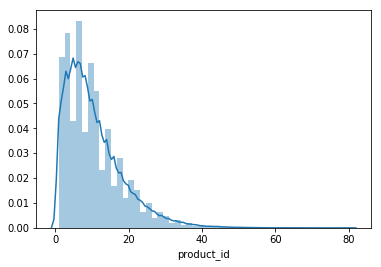

In [66]:
import seaborn as sns
sns.distplot(product_order_counts)

# long right tail -> right skewed

In [67]:
banana_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
25,1492625,2,train,15,1,11,30.0
485,698604,34,train,6,4,13,30.0
623,1864787,43,train,12,5,11,26.0
652,1947848,46,train,20,4,20,11.0
881,13318,56,train,13,1,9,6.0


In [71]:
banana_order_counts = train[train['order_id'].isin(banana_order_ids)].groupby(
    ['order_id']).count()['product_id']
banana_order_counts.mean()

# people who buy bananas buy more items

14.977517889565311

In [72]:
banana_order_counts.describe()

count    18726.000000
mean        14.977518
std          8.491836
min          1.000000
25%          9.000000
50%         13.000000
75%         19.000000
max         80.000000
Name: product_id, dtype: float64

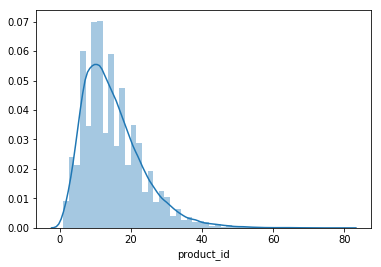

In [74]:
sns.distplot(banana_order_counts)

## Challenge

**Continue to clean and explore your data.** Can you **engineer features** to help predict your target? For the evaluation metric you chose, what score would you get just by guessing? Can you **make a fast, first model** that beats guessing?

We recommend that you use your portfolio project dataset for all assignments this sprint. But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset today. Follow the instructions in the assignment notebook. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!